# Deep Q-learning with openAI Gym LunarLander-v2
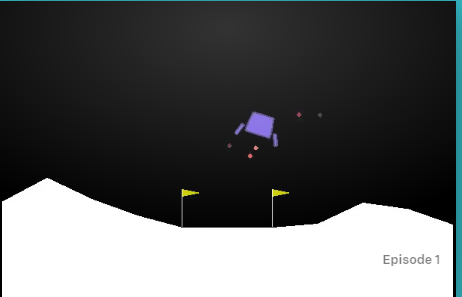
## observation_space
### 8 real values between -inf  and inf
## Action space
### discrete, four choices

# DeepQ learning
## try to learn action-value function Q(s,a)
## Steps:
1. fill ReplayBuffer with state, action, reward next_state tuples by playing with current agent
2. train network by sampling batches of tuples randomly from replaybuffer
3. loss is calculated according to bellman equation and Q(s', a') is calculated with a separate target network for improved stability
4. Add Epsilon-greedy method after to see the difference.
5. Replace L2 with Huber-Loss to see differences 
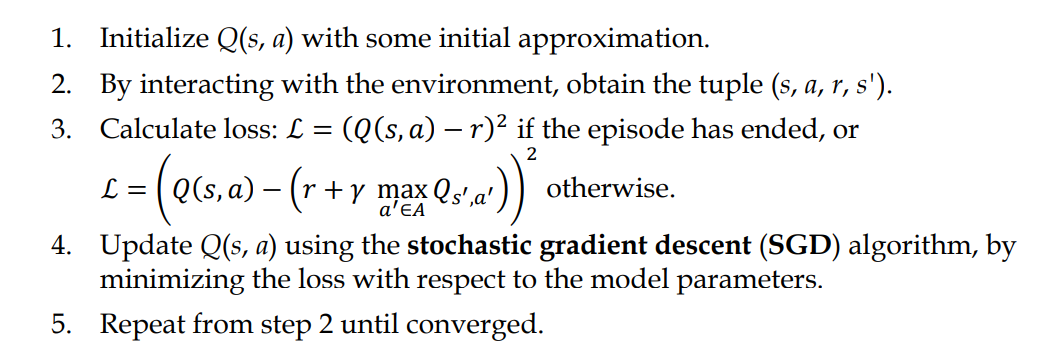
# FUllversion


# First do learning from gym inputs
# after that do learning from pixels

In [4]:
import numpy as np
import gym
env = gym.make('LunarLander-v2')
class NormalizationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space=gym.spaces.Box(low=-1, high=1, shape=(8,), dtype=np.float32)
        
    def observation(self, observation):
        return np.tanh(observation)
    
print(env.observation_space)
print(env.action_space)
#env = NormalizationWrapper(env)
env.reset()

Box(-inf, inf, (8,), float32)
Discrete(4)


array([-0.0059391 ,  1.4105718 , -0.6015824 , -0.0154923 ,  0.00688874,
        0.13626745,  0.        ,  0.        ], dtype=float32)

In [5]:
from collections import namedtuple, deque
import random
ActionPair = namedtuple('ActionPair', ('state','action','next_state', 'reward'))

class ReplayBuffer:
    
    def __init__(self, capacity):
        
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        self.position = 0
        
    def push(self, ActionPair):
        #print(len(self.buffer))
        self.buffer.append(ActionPair)
        
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)
    
    def __repr__(self):
        return f"ReplayBuffer {len(self.buffer)}/{self.capacity}"

In [14]:
# NoisyNet Implentations
# Taken from 
import math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


class NoisyLinear(nn.Linear):
    def __init__(self, in_features, out_features, sigma_init=0.017, bias=True):
        super(NoisyLinear, self).__init__(in_features, out_features, bias=bias)
        self.sigma_weight = nn.Parameter(torch.full((out_features, in_features), sigma_init))
        self.register_buffer("epsilon_weight", torch.zeros(out_features, in_features))
        if bias:
            self.sigma_bias = nn.Parameter(torch.full((out_features,), sigma_init))
            self.register_buffer("epsilon_bias", torch.zeros(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        std = math.sqrt(3 / self.in_features)
        self.weight.data.uniform_(-std, std)
        self.bias.data.uniform_(-std, std)

    def forward(self, input):
        self.epsilon_weight.normal_()
        bias = self.bias
        if bias is not None:
            self.epsilon_bias.normal_()
            bias = bias + self.sigma_bias * self.epsilon_bias.data
        return F.linear(input, self.weight + self.sigma_weight * self.epsilon_weight.data, bias)
    



In [15]:
import torch
import torch.nn as nn


class LunarNet(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LunarNet, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                 nn.ReLU(),
                                 nn.Linear(hidden_dim, hidden_dim),
                                 nn.ReLU(),
                                nn.Linear(hidden_dim, hidden_dim),
                                 nn.ReLU(),
                                 nn.Linear(hidden_dim, output_dim))
    def forward(self, input):
        return self.net(input)
    

class LunarNetWithNoise(nn.Module):
    
        def __init__(self, input_dim, hidden_dim, output_dim):
            super(LunarNetWithNoise, self).__init__()
            self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(hidden_dim, hidden_dim),
                                     nn.ReLU(),
                                    NoisyLinear(hidden_dim, hidden_dim),
                                     nn.ReLU(),
                                    NoisyLinear(hidden_dim, output_dim))
        def forward(self, input):
            return self.net(input)
        
        
class DuelingLunarNetWithNoise(nn.Module):
    
        def __init__(self, input_dim, hidden_dim, output_dim):
            super(DuelingLunarNetWithNoise, self).__init__()
            self.val = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(hidden_dim, hidden_dim),
                                     nn.ReLU(),
                                    NoisyLinear(hidden_dim, hidden_dim),
                                     nn.ReLU(),
                                    NoisyLinear(hidden_dim, 1))

            self.adv = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                         nn.ReLU(),
                         nn.Linear(hidden_dim, hidden_dim),
                         nn.ReLU(),
                        NoisyLinear(hidden_dim, hidden_dim),
                         nn.ReLU(),
                        NoisyLinear(hidden_dim, output_dim))

        def forward(self, input):
            val = self.val(input)
            adv=self.adv(input)
            return val+adv-adv.mean()
        
net = DuelingLunarNetWithNoise(8, 128, 4)
a = net(torch.randn(8).unsqueeze(0))
print(a.dtype)
print(a.max(1)[1])

torch.float32
tensor([1])


In [16]:
import math

class MoonRaker:
    
    def __init__(self, capacity=10000, eps=0.9, gamma=0.99, lr=0.0005, dqn_steps=1, doubleQ=False, device="cpu", threshold=512):
        
        
        self.steps_done = 0
        
        self.device = device
        
        self.eps_start = eps
        self.eps_end = 0.05
        self.eps_decay = 2000
        self.gamma = gamma 
        
        #self.net =  LunarNet(8, 128, 4).to(device) 
        #self.target_net =  LunarNet(8, 128, 4).to(device)
        #self.target_net.load_state_dict(self.net.state_dict())
        
        # Noisy variants
        self.net =  DuelingLunarNetWithNoise(8, 128, 4).to(device) 
        self.target_net = DuelingLunarNetWithNoise(8, 128, 4).to(device)
        self.target_net.load_state_dict(self.net.state_dict())
        
        
        self.target_net.eval()
        
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)
        self.criterion = nn.SmoothL1Loss()
        
        self.memory = ReplayBuffer(capacity)
        self.dqn_steps = dqn_steps
        
        self.doubleQ = doubleQ
    
        self.train_threshold = threshold
        
        
    def sync_nets(self):
        self.target_net.load_state_dict(self.net.state_dict())
        return
    
    def act(self, state, envn):
        """
           
        takes as input a state and computes action
        adds ActionPair to memory
        returns is_done, reward and next state
        """
        
        # add epsilon-greedy later
        sample = random.random()
        #eps_threshold = self.eps_end + (self.eps_start-self.eps_end)*math.exp(-1.*self.steps_done/self.eps_decay)
        #noisy nets
        eps_threshold = 0
        if sample > eps_threshold:
            with torch.no_grad():
                act = self.net(state).max(1)[1].view(1,1)
                
        else:
            act = torch.tensor([[random.randrange(4)]]) 
        
        
        self.steps_done+=1
        obs, reward, is_done, _ = env.step(act.item())
        
        # compute returned values
        next_state = tensorfromstate(obs, self.device)
        obtained_reward = torch.tensor([reward]).float().to(self.device)
        is_done_returned = is_done
        chosen_action = act.to(self.device)
        
        # Code for n-step dqn
        total_reward = reward
        if not is_done:
            for i in range(self.dqn_steps-1):
                obs = tensorfromstate(obs)
                with torch.no_grad():
                    act = self.target_net(state).max(1)[1].item()
                obs, reward, is_done, _ = env.step(act)
                
                total_reward +=self.gamma**(i+1)*reward
                if is_done:
                    break
                
            
        
        final_state = tensorfromstate(obs) if not is_done else None 
        total_reward = torch.tensor([total_reward]).float()
        
        pair = ActionPair(state, chosen_action, final_state, total_reward)
        self.memory.push(pair)
        return next_state, is_done_returned, obtained_reward
        
    
    def learn(self, batch_size):
        """
        one batch of learning 
        """
        if len(self.memory) < self.train_threshold:
            return
        
        state_batch, action_batch, reward_batch, non_final_mask, non_final_next_states = self._get_batch(batch_size)
        
        # These are the Q(a,s) values in bellman
        state_action_values =self.net(state_batch).gather(1, action_batch)
        
        #This calculates max_aQ(a', s') using target net. For final states only reward is calculated
        next_state_values = torch.zeros(batch_size).to(self.device)
        
        with torch.no_grad():
            
            if self.doubleQ:
                
                next_state_acts = self.net(non_final_next_states).max(1)[1]
                next_state_acts = next_state_acts.unsqueeze(0)
                next_state_values[non_final_mask]=self.target_net(non_final_next_states).gather(1, next_state_acts)
            
            else:
                next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
            
        
        expected_state_action_values = (next_state_values.detach()*self.gamma**(self.dqn_steps))+reward_batch

        loss = self.criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss
        
    
    def _get_batch(self, batch_size):
        """
        Sample a batch from memory and transform into trainable form
        """
        
        pairs = self.memory.sample(batch_size)
        batch = ActionPair(*zip(*pairs))
        
    
        state_batch = torch.cat(batch.state).to(self.device)
        action_batch = torch.cat(batch.action).to(self.device)
        reward_batch = torch.cat(batch.reward).to(self.device)
        
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), dtype=torch.bool).to(self.device)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None]).to(self.device)
        
        return state_batch, action_batch, reward_batch, non_final_mask, non_final_next_states
        
        
    def play_episode_in_screen(env):
        """
        show an episode played by the current parameters of agent
        """
        pass
    
    def get_action(self, state):
        with torch.no_grad():
            return this.net(state).max(1)[1].item()
    
    def update_lr(self, lr):
        self.optimizer.param_groups[0]['lr'] = lr
        
    def load_state_dict(self, file):
        state_dict = torch.load(file)
        self.net.load_state_dict(state_dict)
        self.target_net.load_state_dict(state_dict)
        return
    

    def cpu(self):
        self.device = 'cpu'
        self.net.cpu()
        self.target_net.cpu()
        
        return
    
    def cuda(self):
        self.device="cuda"
        self.net.cuda()
        self.target_net.cuda()
        return

In [9]:

def tensorfromstate(state, device="cpu"):
    return torch.FloatTensor(state).unsqueeze(0).to(device)



    

from IPython.display import clear_output
import matplotlib.pyplot as plt
import time
%matplotlib inline

class Logger:
    """
    class to handle Logging during training
    """
    def __init__(self):

        self.data = []
    
    def update(self, data):
        clear_output(wait=True)
        self.data.append(data)
        plt.plot(self.data)
        plt.show()
        
tensorfromstate([1,2,3], device="cuda")    

tensor([[1., 2., 3.]], device='cuda:0')

In [21]:
import statistics
from tqdm.notebook import tqdm
N_episodes = 3000
num_episodes = 0
episode_rewards = []
episode_losses = []
sync_interval = 1000
#logger = Logger()
lr = 0.000625
num_steps=3
completed_episodes=0

Agent= MoonRaker(capacity=100000, lr = lr, dqn_steps=num_steps, doubleQ=True, gamma=0.99,device="cpu", threshold=5000)
#Agent.load_state_dict("solved400.pt")
#torch.autograd.set_detect_anomaly(True)

for i in tqdm(range(N_episodes)):
    state = torch.FloatTensor(env.reset()).unsqueeze(0).to(Agent.device)
    episode_reward = 0
    is_done = False
    while (not is_done):
        
        state, is_done, reward = Agent.act(state, env)
        loss = Agent.learn(64)
        
        episode_reward+=reward.item()
        if loss != None:
            episode_losses.append(loss.item())
        
        if Agent.steps_done%sync_interval == 0:
            Agent.sync_nets()
        
    num_episodes+=1
    episode_rewards.append(episode_reward)
        

    
    if (episode_reward > 200):
        completed_episodes+=1
        print("successful episode")
        #Agent.update_lr(lr/2)
        
                
    if (num_episodes%20==0):
        meanloss = statistics.mean(episode_losses) if len(episode_losses) > 0 else 0
        print(f"{num_episodes} Episodes played. Mean reward of last 20 episodes: {sum(episode_rewards)/len(episode_rewards)}, average loss: {meanloss}, completed_episodes:{completed_episodes}, num_steps:{Agent.steps_done}")
        #logger.update(sum(episode_rewards)/len(episode_rewards))
        if sum(episode_rewards)/len(episode_rewards) > 200:
            print("Solved")
            torch.save(Agent.net.state_dict(), f"Solved{num_episodes}_{num_steps}.pt")
        completed_episodes=0
        episode_rewards = []
        episode_losses = []
        
        
    # sync nets


20 Episodes played. Mean reward of last 20 episodes: -294.1700229969807, average loss: 0, completed_episodes:0, num_steps:911
40 Episodes played. Mean reward of last 20 episodes: -295.30253926534203, average loss: 0, completed_episodes:0, num_steps:1830
60 Episodes played. Mean reward of last 20 episodes: -276.23759648550765, average loss: 0, completed_episodes:0, num_steps:2774
80 Episodes played. Mean reward of last 20 episodes: -299.964633258665, average loss: 0, completed_episodes:0, num_steps:3734
100 Episodes played. Mean reward of last 20 episodes: -305.0440706579946, average loss: 0, completed_episodes:0, num_steps:4702
120 Episodes played. Mean reward of last 20 episodes: -176.24405208203825, average loss: 5.598085685429839, completed_episodes:0, num_steps:5984
140 Episodes played. Mean reward of last 20 episodes: -162.34941833922056, average loss: 7.255634176370989, completed_episodes:0, num_steps:7275
160 Episodes played. Mean reward of last 20 episodes: -129.40582161658259,

KeyboardInterrupt: 

In [98]:
# PLay episode

from PIL import Image
movie_dir = "video_images"
image_folder = "./video_images"

Agent = MoonRaker()
Agent.load_state_dict("Solved260_1.pt")

import os
import moviepy.video.io.ImageSequenceClip


Agent.cpu()

def save_videofile(image_dir, video_name, fps=30):
    image_files = [image_folder+'/'+img for img in sorted(os.listdir(image_folder), key=len) if img.endswith(".png")]
    print(image_files[:10])
    clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
    clip.write_videofile(video_name)



def show_episode(agent, env, save_video=False, video_path="movie.mp4", images_path="./video_images"):
    is_done = False
    obs = env.reset()
    total_reward = 0
    frame = 0
    images = []
    while (not is_done):
        obs = tensorfromstate(obs)
        if save_video:
            data = env.render(mode='rgb_array')
            img = Image.fromarray(data, 'RGB')
            images.append(img)
        else:
            env.render()
        obs, reward, is_done, _ = env.step(Agent.net(obs).max(1)[1].item())
        total_reward+=reward
        frame=+1
    print(f"total reward:{total_reward}")
    if save_video:
        for i, img in enumerate(images):
            img.save(images_path+"/image"+str(i)+".png")
        save_videofile(images_path, video_path, fps=60)
        print(f"saved video as {video_path}")

show_episode(Agent, env, save_video=False)

total reward:255.03156324752226


In [14]:
import os
import moviepy.video.io.ImageSequenceClip

image_folder = "./video_images"

def save_video(image_dir, video_name, fps=30):
    image_files = [image_folder+'/'+img for img in sorted(os.listdir(image_folder), key=len) if img.endswith(".png")]
    print(image_files[:10])
    clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
    clip.write_videofile(video_name)
    
#save_video(image_folder, "rakersuccess.mp4", fps=60)

['./video_images/image0.png', './video_images/image1.png', './video_images/image2.png', './video_images/image3.png', './video_images/image4.png', './video_images/image5.png', './video_images/image6.png', './video_images/image7.png', './video_images/image8.png', './video_images/image9.png']


t:  13%|████████▉                                                          | 32/241 [00:00<00:00, 318.26it/s, now=None]

Moviepy - Building video rakersuccess.mp4.
Moviepy - Writing video rakersuccess.mp4



Moviepy - Done !
Moviepy - video ready rakersuccess.mp4


# Implement Improvements standard improvements to the Q learning 
1. N-Step DQN
2. Double DQN
3. Noisy Network
4. Prioritizes replay buffer
5. (dueling DQN)

# N-Step DQN

# Learn from pixels
# modifications:
1. State is now 4 subsequent frames 84x84 greyscale images
2. actions space is the same

1. Implement wrappers
2. implement convolutional model
3. modify code to work for new setup

In [5]:
# Wrappers
import gym
import numpy as np

env = gym.make('LunarLander-v2')
env = gym.wrappers.Monitor(env, './tmp/cartpole-v0-test_100', force=True)

class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip=skip
        
    def step(self, action):
        total_reward = 0
        done = False
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total_reward+=reward
            if done:
                break
        return obs, total_reward, done, info
        
    
class ImageObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self
        self.observation_space = Box()
        
        
#env = SkipFrame(env, 4)

screen = env.render(mode='rgb_array').transpose((2,0,1))
screen

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)